In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from tsflex.processing import SeriesPipeline, SeriesProcessor, dataframe_func

sys.path.append("../../")
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from code_utils.empatica.acc_processing import ABS_AI
from code_utils.empatica.nonwear import wrist_pipeline
from code_utils.path_conf import processed_mbrain_path, loc_data_dir, figure_dir

USE_PNG = True

## Process the data for each user

In this example, we will use the `ABS-AI`, i.e., the absolute activity value.

This must only be run once, as it takes a some time to compute.<br>
These values are then serialized and saved to disk.

In [3]:
# NOTE: this pipeline performs both the ABS_AI and the nonwear detection
s_pipeline = SeriesPipeline(
    processors=[
        SeriesProcessor(
            dataframe_func(ABS_AI),
            tuple(["ACC_x", "ACC_y", "ACC_z"]),
            n=32 * 1,
            suffix="_1s",
            sigma_i=0,
            step=32,
            scale_factor=64,
        ),
        wrist_pipeline,
    ]
)

retain_cols = ["ABS_AI_1s"]

In [4]:
# this code takes around 3 minutes
for user in ['001', '002', '003', '004']:
    user = f"MBRAIN21-{user}"
    out_list = []
    for acc_file in tqdm(
        list(processed_mbrain_path.glob(f"{user}*empatica.E4*/acc*.parquet"))
    ):
        # iterate over each date
        df_acc = (
            pd.read_parquet(acc_file)
            .drop_duplicates(subset="timestamp")
            .set_index("timestamp")
        )
        df_tmp = (
            pd.read_parquet(acc_file.parent / ("tmp" + acc_file.name[3:]))
            .drop_duplicates(subset="timestamp")
            .set_index("timestamp")
        )
        df_eda = (
            pd.read_parquet(acc_file.parent / ("gsr" + acc_file.name[3:]))
            .drop_duplicates(subset="timestamp")
            .set_index("timestamp")
        )

        # apply the pipeline
        out = {
            s.name: s
            for s in s_pipeline.process(
                [df_acc, df_tmp, df_eda], return_df=False, return_all_series=False
            )
        }
        df_out = (
            pd.DataFrame({k: out[k] for k in retain_cols})
            .dropna(how="any", axis=0)
            .astype(np.float32)
        )
        old_shape = df_out.shape[0]
        on_off_mask = out["On_Wrist_SQI_smoothened"]
        on_off_mask = (
            on_off_mask[~on_off_mask.index.duplicated()]
            .reindex(index=df_out.index, method="bfill")
            .fillna(True)
        )
        # filter out the off wrist periods
        df_out = df_out[on_off_mask]
        out_list.append(df_out)

        if old_shape != df_out.shape[0]:
            print(
                f"{user} - {acc_file.stem[4:]} -  {old_shape:,}  -  {df_out.shape[0]:,}"
            )

    df_out = pd.concat(out_list, axis=0, ignore_index=False).sort_index()
    df_out.index = df_out.index.round("1s", ambiguous='NaT')
    df_out = df_out[~df_out.index.isna()]
    df_out = df_out[~df_out.index.duplicated()]
    df_out.to_parquet(loc_data_dir / f"ABS_AI_{user}.parquet")

del (
    out,
    out_list,
    df_out,
    on_off_mask,
    old_shape,
    df_acc,
    df_tmp,
    df_eda,
    user,
    acc_file,
)


  0%|          | 0/91 [00:00<?, ?it/s]

MBRAIN21-001 - 2022_08_12 -  77,750  -  77,680
MBRAIN21-001 - 2022_08_17 -  80,078  -  79,734
MBRAIN21-001 - 2022_08_29 -  76,757  -  76,742
MBRAIN21-001 - 2022_09_09 -  72,083  -  72,017
MBRAIN21-001 - 2022_09_16 -  79,986  -  79,927
MBRAIN21-001 - 2022_09_27 -  76,922  -  76,891
MBRAIN21-001 - 2022_09_28 -  83,477  -  83,430
MBRAIN21-001 - 2022_10_09 -  68,166  -  67,992
MBRAIN21-001 - 2022_10_18 -  59,866  -  59,807
MBRAIN21-001 - 2022_10_24 -  81,694  -  81,596
MBRAIN21-001 - 2022_10_31 -  75,886  -  75,839


  0%|          | 0/79 [00:00<?, ?it/s]

MBRAIN21-002 - 2022_09_04 -  69,468  -  68,861
MBRAIN21-002 - 2022_09_06 -  56,292  -  54,222
MBRAIN21-002 - 2022_09_08 -  47,623  -  44,744
MBRAIN21-002 - 2022_09_09 -  68,552  -  63,138
MBRAIN21-002 - 2022_09_10 -  38,071  -  32,940
MBRAIN21-002 - 2022_09_12 -  37,722  -  36,146
MBRAIN21-002 - 2022_09_13 -  45,999  -  42,452
MBRAIN21-002 - 2022_09_14 -  47,380  -  44,202
MBRAIN21-002 - 2022_09_15 -  73,866  -  70,999
MBRAIN21-002 - 2022_09_18 -  60,904  -  59,731
MBRAIN21-002 - 2022_09_19 -  76,497  -  74,304
MBRAIN21-002 - 2022_09_20 -  75,662  -  72,038
MBRAIN21-002 - 2022_09_21 -  15,218  -  14,749
MBRAIN21-002 - 2022_09_26 -  71,237  -  60,364
MBRAIN21-002 - 2022_09_27 -  3,751  -  3,729
MBRAIN21-002 - 2022_09_28 -  70,064  -  64,655
MBRAIN21-002 - 2022_09_29 -  63,763  -  60,561
MBRAIN21-002 - 2022_09_30 -  5,478  -  4,926
MBRAIN21-002 - 2022_10_03 -  65,422  -  61,545
MBRAIN21-002 - 2022_10_04 -  32,264  -  30,871
MBRAIN21-002 - 2022_10_05 -  41,196  -  39,505
MBRAIN21-002 - 20

  0%|          | 0/61 [00:00<?, ?it/s]

MBRAIN21-003 - 2021_08_31 -  14,466  -  14,441
MBRAIN21-003 - 2021_09_01 -  63,631  -  63,516
MBRAIN21-003 - 2021_09_03 -  69,364  -  69,212
MBRAIN21-003 - 2021_09_08 -  47,002  -  46,418
MBRAIN21-003 - 2021_09_11 -  43,392  -  42,936
MBRAIN21-003 - 2021_09_12 -  58,250  -  56,623
MBRAIN21-003 - 2021_09_14 -  53,914  -  52,208
MBRAIN21-003 - 2021_09_13 -  66,336  -  66,213
MBRAIN21-003 - 2021_10_26 -  68,714  -  67,270
MBRAIN21-003 - 2021_10_27 -  46,703  -  46,661
MBRAIN21-003 - 2021_10_28 -  28,184  -  26,972
MBRAIN21-003 - 2021_10_29 -  64,536  -  63,672
MBRAIN21-003 - 2021_11_04 -  44,413  -  36,718
MBRAIN21-003 - 2021_11_05 -  45,824  -  45,667
MBRAIN21-003 - 2021_11_15 -  32,731  -  31,967
MBRAIN21-003 - 2021_11_16 -  29,489  -  29,393
MBRAIN21-003 - 2021_11_29 -  45,243  -  45,156
MBRAIN21-003 - 2021_12_02 -  35,420  -  28,041


  0%|          | 0/105 [00:00<?, ?it/s]

MBRAIN21-004 - 2021_10_04 -  46,933  -  46,633
MBRAIN21-004 - 2021_10_05 -  57,086  -  57,047
MBRAIN21-004 - 2021_10_06 -  67,116  -  66,776
MBRAIN21-004 - 2021_10_10 -  59,593  -  59,008
MBRAIN21-004 - 2021_10_11 -  49,863  -  49,423
MBRAIN21-004 - 2021_10_12 -  50,258  -  47,592
MBRAIN21-004 - 2021_10_16 -  50,765  -  49,762
MBRAIN21-004 - 2021_10_17 -  78,185  -  77,413
MBRAIN21-004 - 2021_10_20 -  33,478  -  33,068
MBRAIN21-004 - 2021_10_22 -  49,826  -  47,560
MBRAIN21-004 - 2021_10_25 -  47,156  -  43,971
MBRAIN21-004 - 2021_10_26 -  52,657  -  52,243
MBRAIN21-004 - 2021_10_27 -  51,489  -  51,197
MBRAIN21-004 - 2021_10_28 -  40,449  -  40,108
MBRAIN21-004 - 2021_10_29 -  39,683  -  39,239
MBRAIN21-004 - 2021_10_30 -  41,355  -  41,110
MBRAIN21-004 - 2021_10_31 -  71,785  -  71,751
MBRAIN21-004 - 2021_11_01 -  56,120  -  55,584
MBRAIN21-004 - 2021_11_06 -  47,934  -  46,964
MBRAIN21-004 - 2021_11_09 -  18,761  -  18,688
MBRAIN21-004 - 2021_11_12 -  53,221  -  50,350
MBRAIN21-004 

## Analyze the data ratios for the `window of interest`

In [5]:
def _plot_data_ratios(data_ratios, ax = None, i=0):
    # As the window of interest lies within one day, we can use the date as identifier
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 3.5))
    sns.ecdfplot(
        data_ratios,
        stat="count",
        complementary=True,
        ax=ax,
        lw=2,
        color=sns.color_palette("coolwarm")[i],
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Available data ratio")
    ax.set_ylabel("# samples")
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(0, 88)
    ax.grid(True)
    return ax

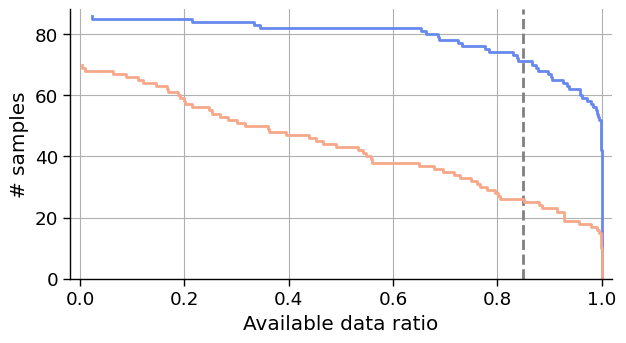

In [9]:
ax = None
for i, user in enumerate(['MBRAIN21-001', 'MBRAIN21-004']):
    df_ABS_AI_user = pd.read_parquet(f"ABS_AI_{user}.parquet")
    sns.set_context("paper", font_scale=1.5)
    window_of_interest = "11:00:00", "13:00:00"
    window_of_interest_duration = pd.to_timedelta(window_of_interest[1]) - pd.to_timedelta(
        window_of_interest[0]
    )

    df_wi = df_ABS_AI_user.between_time(*window_of_interest).copy()
    import seaborn as sns

    # As the window of interest lies within one day, we can use the date as identifier
    data_ratios = df_wi.groupby(df_wi.index.date).size() / (window_of_interest_duration.total_seconds())
    if ax is None:
        ax = _plot_data_ratios(data_ratios, i=i)
        ax.axvline(x=0.85, ls="--", lw=2, color="grey")
    else:
        _plot_data_ratios(data_ratios, ax=ax, i=4*i)
    # ax.set_title(f"Data availability between {window_of_interest[0]} - {window_of_interest[1]} - {user}")

plt.show()

## Bootstrapping to estimate the gaps

In [12]:
df_ABS_AI_user = pd.read_parquet(loc_data_dir / "ABS_AI_MBRAIN21-001.parquet")
df_wi = df_ABS_AI_user.between_time(*window_of_interest).copy()

The outcoms of this `Bootstrapping` procedure is wearable modality specific.

In [15]:
# Visualize the window of interest data
user = "MBRAIN21-001"
df_ABS_AI_user = pd.read_parquet(loc_data_dir / f"ABS_AI_{user}.parquet")
window_of_interest = "11:00:00", "13:00:00"
window_of_interest_duration = pd.to_timedelta(window_of_interest[1]) - pd.to_timedelta(
    window_of_interest[0]
)
df_wi = df_ABS_AI_user.between_time(*window_of_interest).copy()
data_ratios = df_wi.groupby(df_wi.index.date).size() / (
    window_of_interest_duration.total_seconds()
)

# select a day with a high data ratio
date_of_interest = data_ratios[data_ratios > 0.99].sample(1).index[0]

# RAW-ACC user
df_acc = []
for acc_file in tqdm(
    list(
        processed_mbrain_path.glob(
            f"{user}*empatica.E4*/acc*{date_of_interest.strftime('%Y_%m_%d')}*.parquet"
        )
    )
):
    df_acc.append(
        pd.read_parquet(acc_file)
        .drop_duplicates(subset="timestamp")
        .set_index("timestamp")
    )

df_acc_dt = pd.concat(df_acc, axis=0, ignore_index=False).sort_index()

df_abs_ai_dt = df_ABS_AI_user[date_of_interest.strftime('%Y-%m-%d')]

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_3926307/1316511179.py:33: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_abs_ai_dt = df_ABS_AI_user[date_of_interest.strftime('%Y-%m-%d')]


start 3151 wrap 3450
start 3834 wrap 4974


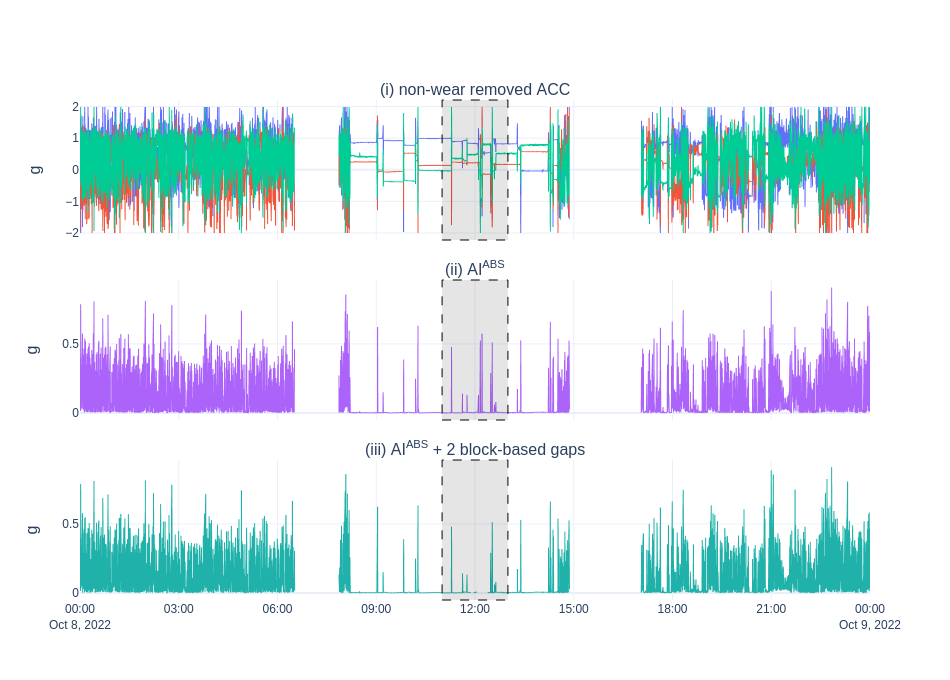

Dash app running on http://127.0.0.1:8055/


In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly_resampler import FigureResampler
import plotly.express as px

fig = FigureResampler(
    make_subplots(
        **dict(rows=3, cols=1, shared_xaxes=True),
        subplot_titles=[
            "(i) non-wear removed ACC",
            "(ii) AI<sup>ABS</sup>",
            "(iii) AI<sup>ABS</sup> + 2 block-based gaps",
        ],
        vertical_spacing=0.08
    ),
    default_n_shown_samples=2000,
)

scatter_kwargs = dict(line_width=1)
for c in df_acc_dt.columns:
    fig.add_trace(
        go.Scattergl(name=c, showlegend=False, **scatter_kwargs),
        hf_x=df_acc_dt.index,
        hf_y=df_acc_dt[c] / 64,
        row=1,
        col=1,
    )

fig.add_trace(
    go.Scattergl(name="AI_ABS", showlegend=False, **scatter_kwargs),
    hf_x=df_abs_ai_dt.index,
    hf_y=df_abs_ai_dt["ABS_AI_1s"],
    row=2,
    col=1,
)

# Show the gaps
slc_wi = df_abs_ai_dt.between_time(*window_of_interest)
start_time = slc_wi.index[0]
end_time = slc_wi.index[-1]

# multiple (smaller) masked ranged
data_ratio = 0.6
nb_ranges = 2
ratios = np.random.randint(10, 100, size=nb_ranges)
ratios = ratios / ratios.sum()
# mooier om te blijven werken met een pd.Series
n_mask = int(len(slc_wi) * (1 - data_ratio))
slc_wi_bs = slc_wi.copy()
for ratio in ratios:
    start_idx = np.random.randint(0, len(slc_wi_bs) - 1)
    wrap_idx = (start_idx + int(n_mask / nb_ranges * ratio)) % len(slc_wi_bs)
    print("start", start_idx, "wrap", wrap_idx)
    if start_idx < wrap_idx:
        # normal case
        slc_wi_bs.iloc[start_idx:wrap_idx] = None
    else:  # untile start_indix and from wrap_idx to end
        slc_wi_bs.iloc[start_idx:] = None
        slc_wi_bs.iloc[:wrap_idx] = None

df_abs_ai_gaps = df_abs_ai_dt.copy()
df_abs_ai_gaps.loc[start_time:end_time] = None
df_abs_ai_gaps = pd.concat(
    [df_abs_ai_gaps.dropna(), slc_wi_bs.dropna()], axis=0, ignore_index=False
).sort_index()
fig.add_trace(
    go.Scattergl(
        name="AI_ABS", showlegend=False, line_color='lightseagreen', **scatter_kwargs
    ),
    hf_x=df_abs_ai_gaps.index,
    hf_y=df_abs_ai_gaps["ABS_AI_1s"],
    row=3,
    col=1,
)

# draw a vrect on all subplots
start_time = slc_wi.index[0]
end_time = slc_wi.index[-1]
# fig.add_vrect(x0=start_time, x1=end_time, line_color='black', line_dash='dash', row='all', col='all')
fig.add_vrect(
    x0=start_time,
    x1=end_time,
    fillcolor="rgba(0,0,0,0.1)",
    row="all",
    col="all",
    line_color="black",
    line_width=1,
    line_dash="dash",
)
fig.update_yaxes(title_text="g", titlefont_size=16)
fig.update_layout(template="plotly_white", height=680, width=750)

if USE_PNG:
    fig.show(renderer="png", width=950, height=680)

fig.show_dash(mode="external", port=8055)


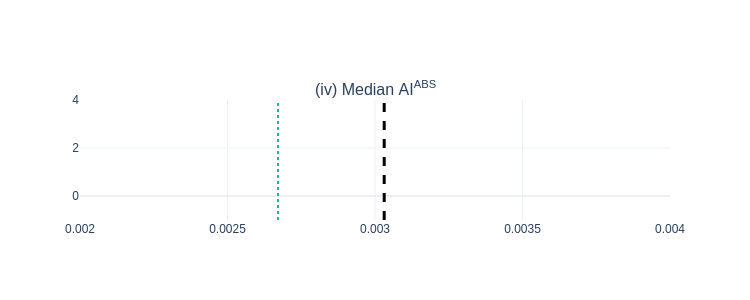

In [24]:
fig2 = make_subplots(rows=1, cols=1, subplot_titles=["(iv) Median AI<sup>ABS</sup>"])
fig2.add_trace({}, row=1, col=1)
fig2.add_vline(x=slc_wi.median().iloc[0], line_color='black', line_width=3, line_dash='dash', row=1, col=1)
fig2.add_vline(x=slc_wi_bs.median().iloc[0], line_color='lightseagreen', line_dash='dot', row=1, col=1)
# fig2.update_layout(title='(iv) Median AI<sup>ABS</sup>', title_x=0.5)
fig2.update_xaxes(range=[0.002, 0.004])
fig2.update_layout(template='plotly_white')
if USE_PNG:
    fig2.show(renderer='png', width=750, height=300)
fig2.write_html(figure_dir / 'med_abs_ai.html', include_plotlyjs='cdn', full_html=False, auto_open=False)

In [25]:
sns.set_context("talk")

# ----------------------- Hyperparameters -----------------------
# the threshold to test
data_ratio_threshold_grid = [0.6, 0.7, 0.8, 0.9, 0.9, 0.95][:]
nb_bootstraps = 200   # the number of bootstrap iterations to perform
quantiles = [0.25, 0.5, 0.75, 0.9][1:]  # the quantile metrics to compute
# ----------------------------------------------------------------

feat_list = []
# iterate over 3 complete windows of interest
for date in tqdm(data_ratios[data_ratios > 0.99].index.values[2::6][-3:]):

    slc_wi = df_wi.loc[str(date)]["ABS_AI_1s"]

    # compute the ground truth value
    q_gts = np.quantile(slc_wi, quantiles)
    for q, q_val in zip(quantiles, q_gts):
        feat_list.append([date, f"q_{q}", q_val, "population", 1])
    reference_mean = np.mean(slc_wi)
    feat_list.append([date, "mean", reference_mean, "population", 1])

    # iterate over the different data ratios
    for data_ratio in data_ratio_threshold_grid:
        for _ in range(nb_bootstraps):
            # sample without replacement (as the data may contain gaps)
            slc_wi_bs = slc_wi.sample(frac=data_ratio, replace=False)
            for (q, q_val), q_gt in zip(
                zip(quantiles, np.quantile(slc_wi_bs, quantiles)), q_gts
            ):
                feat_list.append(
                    [
                        date,
                        f"q_{q}",
                        q_val,
                        "bootstrap",
                        data_ratio,
                        "sampling",
                        len(slc_wi_bs) / len(slc_wi),
                        q_gt,
                    ]
                )
            feat_list.append(
                [
                    date,
                    "mean",
                    np.mean(slc_wi_bs),
                    "bootstrap",
                    data_ratio,
                    "sampling",
                    len(slc_wi_bs) / len(slc_wi),
                    reference_mean,
                ]
            )

            # time based gap masking
            start_idx = np.random.randint(0, len(slc_wi) - 1)
            wrap_idx = (start_idx + int(len(slc_wi) * (1 - data_ratio))) % len(slc_wi)
            if (
                wrap_idx < start_idx
            ):  # wrap around -> reverse the indices to obtain the correct slice
                slc_wi_bs = slc_wi.iloc[wrap_idx:start_idx].values
            else:  # untile start_indix and from wrap_idx to end
                slc_wi_bs = np.concatenate(
                    [slc_wi.iloc[:start_idx].values, slc_wi.iloc[wrap_idx:].values]
                )

            # slc_wi_bs = slc_wi.sample(frac=data_ratio, replace=False)
            for (q, q_val), q_gt in zip(
                zip(quantiles, np.quantile(slc_wi_bs, quantiles)), q_gts
            ):
                feat_list.append(
                    [
                        date,
                        f"q_{q}",
                        q_val,
                        "bootstrap",
                        data_ratio,
                        "range mask",
                        len(slc_wi_bs) / len(slc_wi),
                        q_gt,
                    ]
                )
            feat_list.append(
                [
                    date,
                    "mean",
                    np.mean(slc_wi_bs),
                    "bootstrap",
                    data_ratio,
                    "range mask",
                    len(slc_wi_bs) / len(slc_wi),
                    reference_mean,
                ]
            )

            # multiple (smaller) masked ranged
            nb_ranges = 2
            ratios = np.random.randint(10, 100, size=nb_ranges)
            ratios = ratios / ratios.sum()
            n_mask = int(len(slc_wi) * (1 - data_ratio))
            slc_wi_bs = slc_wi.copy().values
            for ratio in ratios:
                start_idx = np.random.randint(0, len(slc_wi_bs / 2) - 1)
                wrap_idx = (start_idx + int(n_mask * ratio)) % len(slc_wi_bs)
                if (
                    wrap_idx < start_idx
                ):  # wrap around -> reverse the indices to obtain the correct slice
                    slc_wi_bs = slc_wi_bs[wrap_idx:start_idx]
                else:  # untile start_indix and from wrap_idx to end
                    slc_wi_bs = np.concatenate(
                        [slc_wi_bs[:start_idx], slc_wi_bs[wrap_idx:]]
                    )

            # slc_wi_bs = slc_wi.sample(frac=data_ratio, replace=False)
            for (q, q_val), q_gt in zip(
                zip(quantiles, np.quantile(slc_wi_bs, quantiles)), q_gts
            ):
                feat_list.append(
                    [
                        date,
                        f"q_{q}",
                        q_val,
                        "bootstrap",
                        data_ratio,
                        "range mask 2",
                        len(slc_wi_bs) / len(slc_wi),
                        q_gt,
                    ]
                )
            feat_list.append(
                [
                    date,
                    "mean",
                    np.mean(slc_wi_bs),
                    "bootstrap",
                    data_ratio,
                    "range mask 2",
                    len(slc_wi_bs) / len(slc_wi),
                    reference_mean,
                ]
            )

df_bs = pd.DataFrame(
    feat_list,
    columns=[
        "date",
        "quantile",
        "value",
        "source",
        "data_ratio",
        "bootstrap_method",
        "data_ratio_val",
        "q_ground_truth",
    ],
)

df_bs["q_rel"] = (
    (df_bs["value"] - df_bs["q_ground_truth"]) / (df_bs["q_ground_truth"] + 0.02)
) * 100

  0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
vis_slc = df_bs[(df_bs.data_ratio == 0.6) & (df_bs.date.astype(str) == '2022-11-01') & (df_bs.bootstrap_method == 'range mask') & (df_bs['quantile'] == 'q_0.5')]

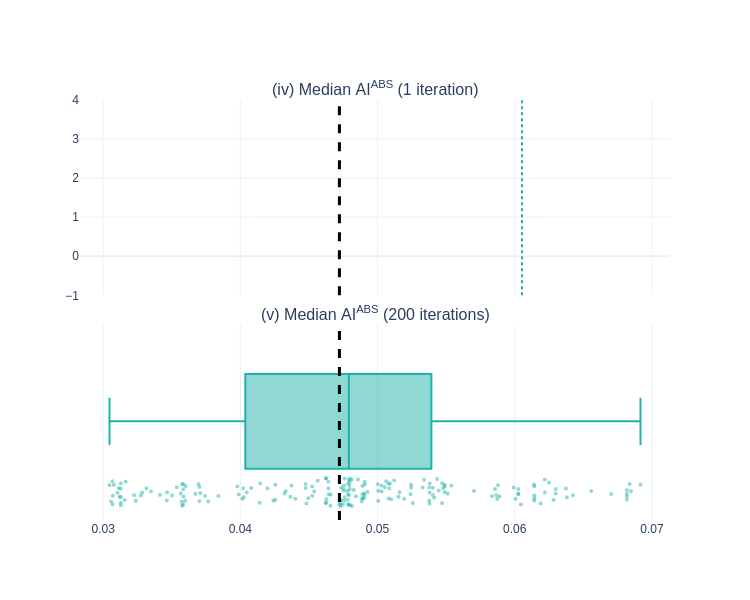

In [28]:
fig2 = make_subplots(rows=2, cols=1, subplot_titles=["(iv) Median AI<sup>ABS</sup> (1 iteration)", '(v) Median AI<sup>ABS</sup> (200 iterations)'], shared_xaxes=True, vertical_spacing=0.07)
fig2.add_trace({})
fig2.add_vline(x=0.0605271, line_color='lightseagreen', line_dash='dot', row=1, col=1)

fig2.add_trace(go.Box(x=vis_slc['value'].values, line_color='lightseagreen', boxpoints='all', marker_size=4, marker_opacity=0.5, jitter=0.3, showlegend=False, name=""), row=2, col=1)
fig2.add_vline(x=vis_slc['q_ground_truth'].iloc[0], line_color='black', line_width=3, line_dash='dash', row='all', col='all')
fig2.update_layout(template='plotly_white', height=600)
if USE_PNG:
    fig2.show(renderer='png', width=750, height=600)
fig2.write_html(figure_dir / 'med_abs_ai_v2.html', include_plotlyjs='cdn', full_html=False, auto_open=False)

In [29]:
df_bs['quantile'].unique()

array(['q_0.5', 'q_0.75', 'q_0.9', 'mean'], dtype=object)

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



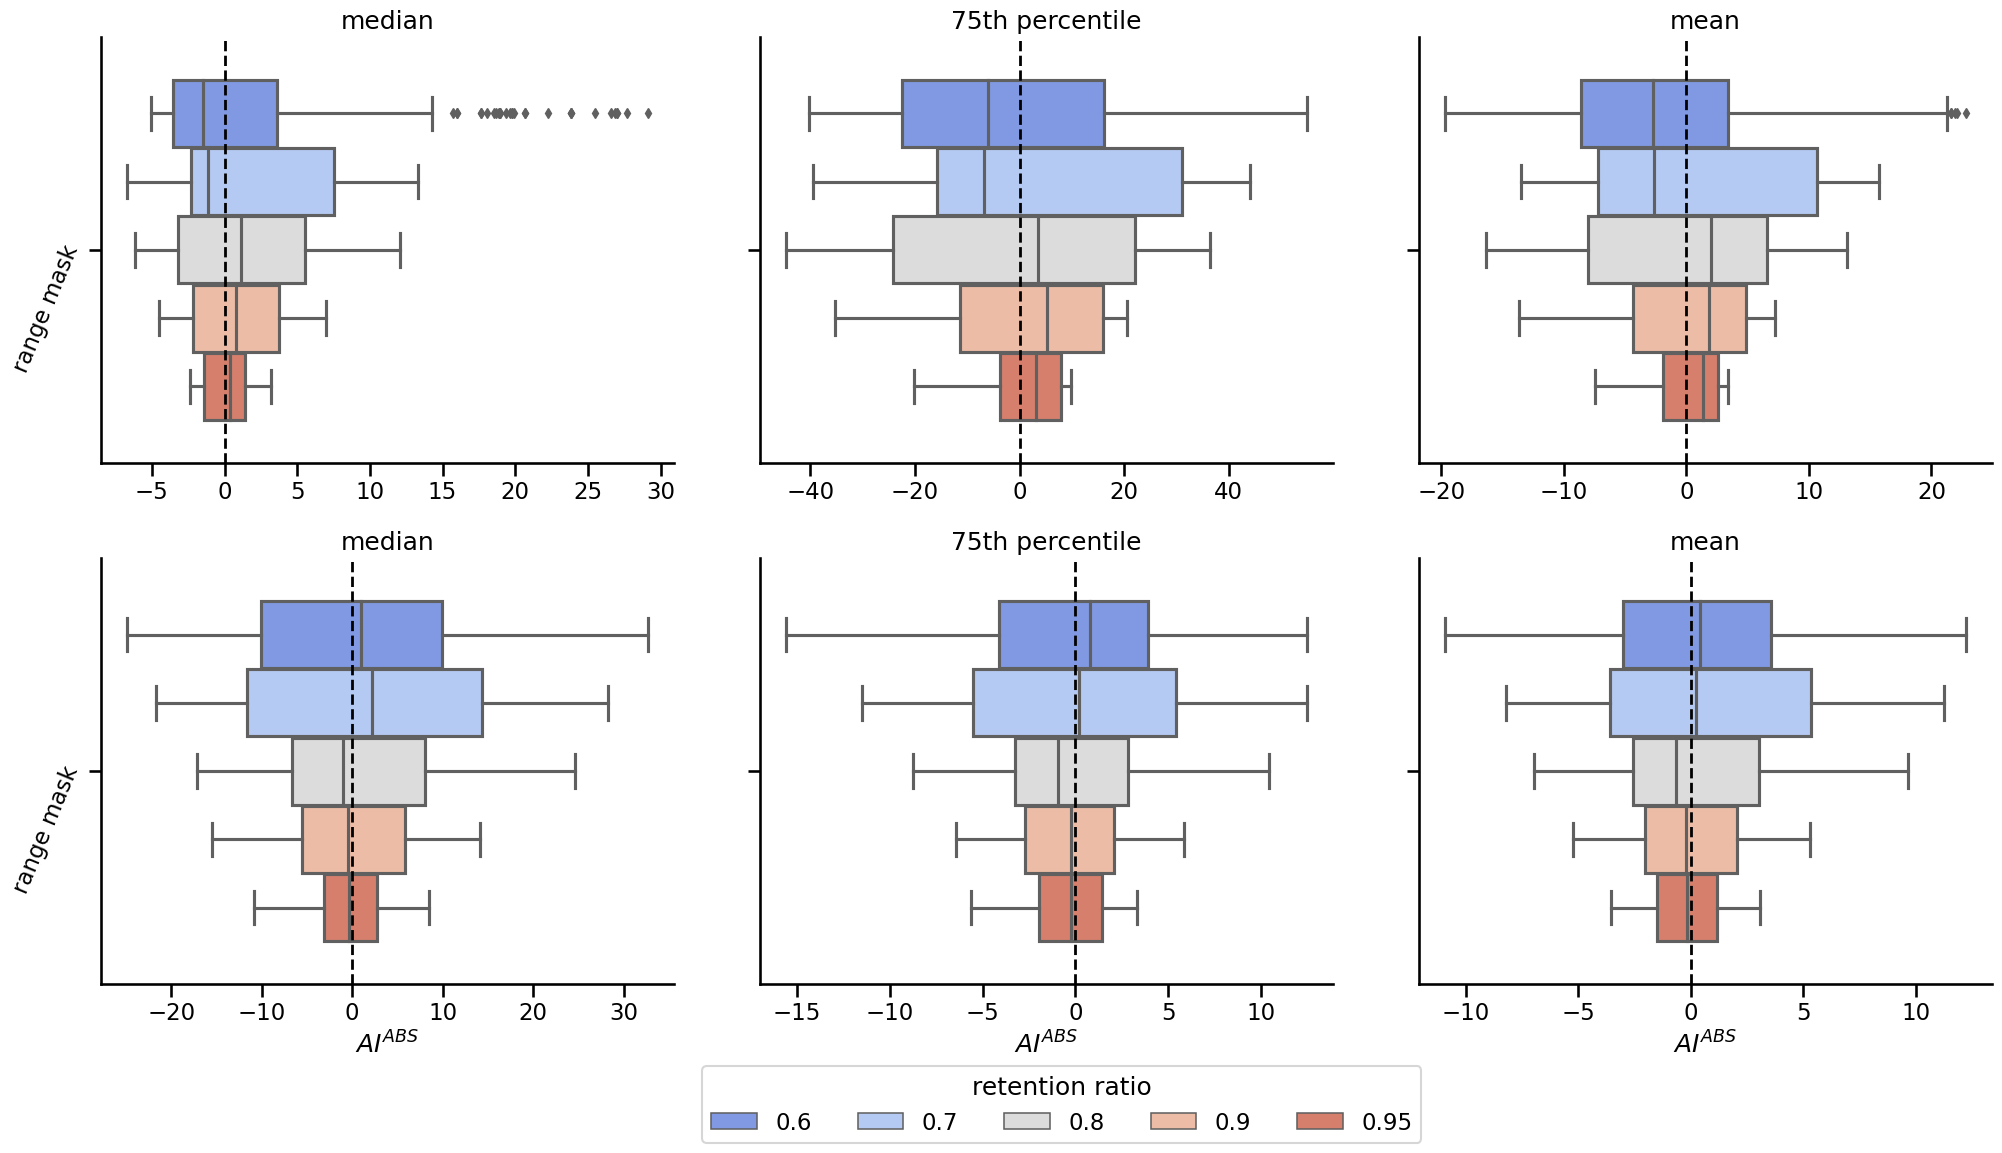

In [30]:
relative_x = True
df_vis = df_bs[
    (df_bs.date.isin(df_bs.date.unique()[::2]))
    & (df_bs.bootstrap_method.isin([None, "range mask"]))
    # & (df_bs.bootstrap_method != "range mask 2")
    & (df_bs["quantile"].isin(["q_0.5", "q_0.75", "mean"][:]))
].assign(
    quantile=lambda D: D["quantile"].map(
        lambda x: {
            "q_0.5": "median",
            "q_0.75": "75th percentile",
        }.get(x, x)
    )
).rename(columns={'data_ratio': 'retention ratio'})
g = sns.catplot(
    data=df_vis[df_vis['retention ratio'] < 1.0],
    # **dict(kind="strip", s=7, dodge=True, aspect=1.3),
    **dict(kind="box", aspect=1.3),
    col="quantile",
    x="q_rel" if relative_x else "value",
    y="bootstrap_method",
    hue="retention ratio",
    sharex="col" if not relative_x else False,
    palette="coolwarm",
    height=5.5,
    row="date",
    # col_wrap=2,
    # alpha=0.5,
)

for (row_idx, date), (col_idx, q_name) in itertools.product(
    enumerate(g.row_names), enumerate(g.col_names)
):
    ax = g.axes[row_idx, col_idx]
    s = df_vis[
        (df_vis.date == date) & (df_vis['retention ratio'] == 1.0) & (df_vis["quantile"] == q_name)
    ]
    assert len(s) == 1
    s = s.iloc[0]
    if relative_x:
        ax.axvline(0, lw=2, ls="--", color="k")
    else:
        ax.axvline(s.value, lw=2, ls="--", color="k")
    # max_lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]))
    # ax.set_xlim(-max_lim, max_lim)
    # ax.set_xlim(0, ax.get_xlim()[1])

# rotate y tick labels
for ax in g.axes[:, 0]:
    ax.set_ylabel("")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=67.5)

for ax in g.axes[-1, :]:
    ax.set_xlabel("$AI^{ABS}$")
g.set_titles("{col_name}")

# move the legend to the bottom
sns.move_legend(
    g, "upper left", bbox_to_anchor=(0.35, 0.025), ncol=5, frameon=True
)
plt.subplots_adjust(wspace=0.15)


/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/tmp/ipykernel_3926307/2526262206.py:53: UserWarning:

FixedFormatter should only be used together with FixedLocator



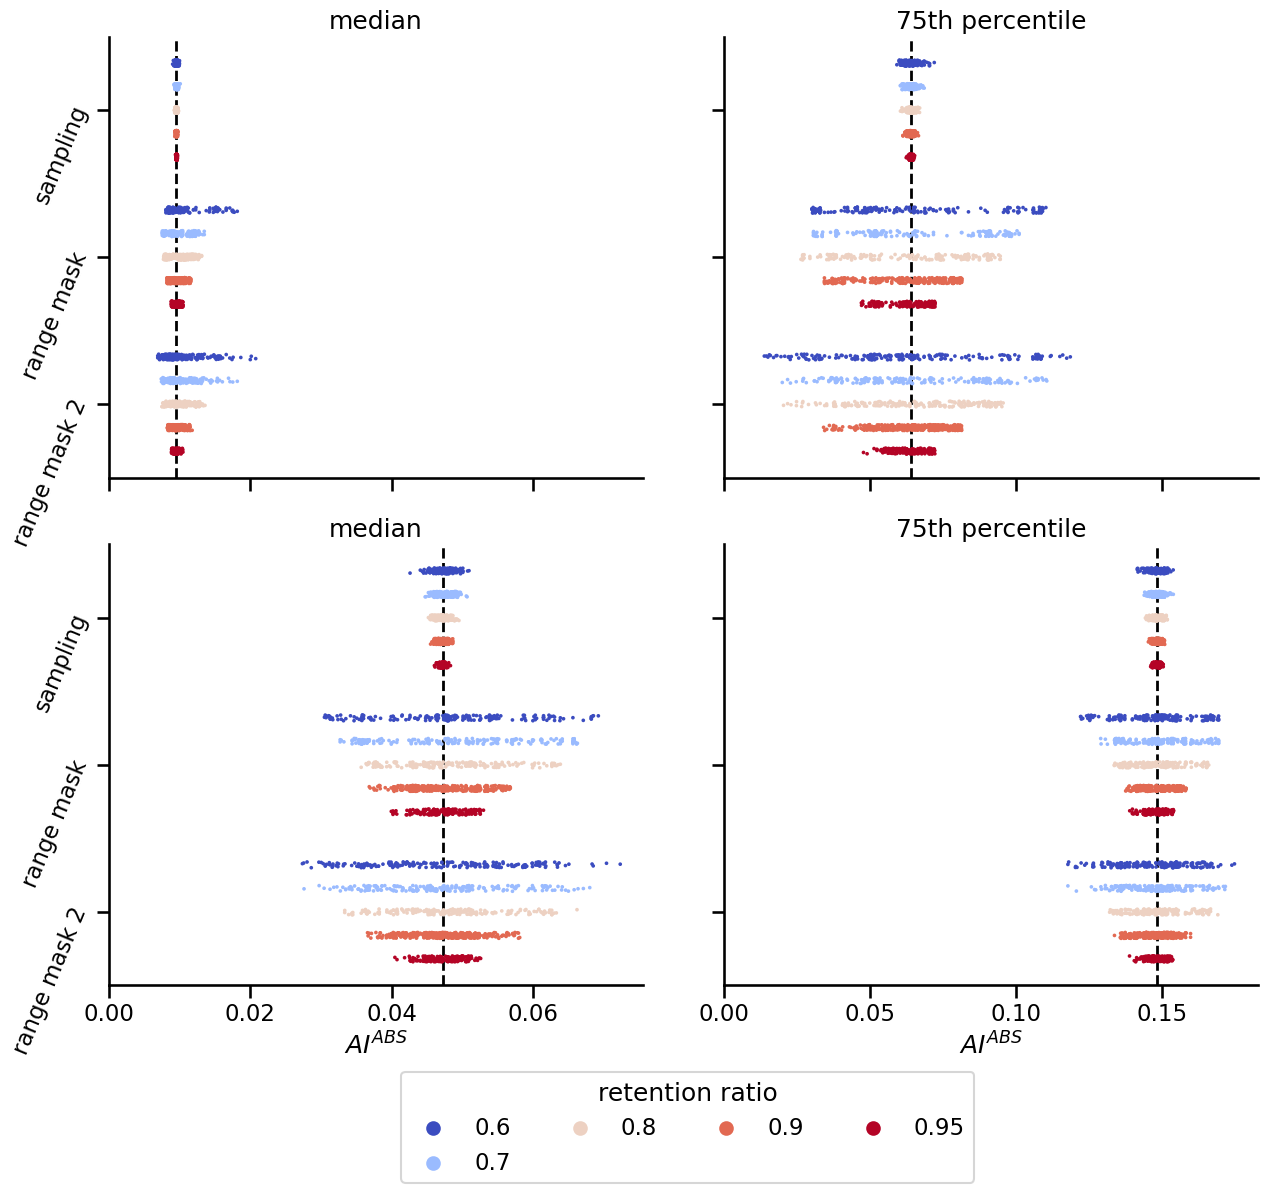

In [31]:
relative_x = False
df_vis = df_bs[
    (df_bs.date.isin(df_bs.date.unique()[::2]))
    # & (df_bs.bootstrap_method.isin([Non, "range mask"]))
    & (df_bs["quantile"].isin(["q_0.5", "q_0.75", "mean"][:2]))
].assign(
    quantile=lambda D: D["quantile"].map(
        lambda x: {
            "q_0.5": "median",
            "q_0.75": "75th percentile",
        }.get(x, x)
    )
).rename(columns={'data_ratio': 'retention ratio'})
g = sns.catplot(
    data=df_vis[df_vis['retention ratio'] < 1.0],
    **dict(kind="strip", s=7, dodge=True, aspect=1.3),
    # **dict(kind="box", aspect=1.3),
    col="quantile",
    x="q_rel" if relative_x else "value",
    y="bootstrap_method",
    hue="retention ratio",
    sharex="col" if not relative_x else False,
    # sharex=False,
    palette="coolwarm",
    # color=sns.color_palette("coolwarm")[0],
    height=5.5,
    row="date",
    # col_wrap=2,
    # alpha=0.5,
)

for (row_idx, date), (col_idx, q_name) in itertools.product(
    enumerate(g.row_names), enumerate(g.col_names)
):
    ax = g.axes[row_idx, col_idx]
    s = df_vis[
        (df_vis.date == date) & (df_vis['retention ratio'] == 1.0) & (df_vis["quantile"] == q_name)
    ]
    assert len(s) == 1
    s = s.iloc[0]
    if relative_x:
        ax.axvline(0, lw=2, ls="--", color="k")
    else:
        ax.axvline(s.value, lw=2, ls="--", color="k")
    # max_lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]))
    # ax.set_xlim(-max_lim, max_lim)
    ax.set_xlim(0, ax.get_xlim()[1])

# rotate y tick labels
for ax in g.axes[:, 0]:
    ax.set_ylabel("")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=67.5)
    # ax.set_yticklabels("")

for ax in g.axes[-1, :]:
    ax.set_xlabel("$AI^{ABS}$")
g.set_titles("{col_name}")

# move the legend to the bottom
sns.move_legend(g, "upper left", bbox_to_anchor=(0.335, 0.02), ncol=4, frameon=True)
plt.subplots_adjust(wspace=0.15)
